In [1]:
#Import library

import os
import cv2
import itertools
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Conv2D, MaxPool2D, Flatten
from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical

# Preprocessing

In [2]:
#menjadikan gambar abu abu + crop gambar 

def detect_face(img):
    img = img[70:195,78:172]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (50, 50))
    return img

In [3]:
def print_progress(val, val_len, folder, bar_size=20):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] (%d samples)\t label : %s \t\t" % (progr, val+1, folder), end="\r")

In [4]:
dataset_folder = "dataset/"
# source: http://vis-www.cs.umass.edu/lfw/

names = []
images = []
for folder in os.listdir(dataset_folder):
    files = os.listdir(os.path.join(dataset_folder, folder))[:150]
    if len(files) < 50 :
        continue
    for i, name in enumerate(files): 
        if name.find(".jpg") > -1 :
            img = cv2.imread(os.path.join(dataset_folder + folder, name))
            img = detect_face(img) # detect face using mtcnn and crop to 100x100
            if img is not None :
                images.append(img)
                names.append(folder)

                print_progress(i, len(files), folder)


[####################] (77 samples)	 label : Ariel_Sharon 		
[####################] (150 samples)	 label : Colin_Powell 		
[####################] (121 samples)	 label : Donald_Rumsfeld 		
[####################] (150 samples)	 label : George_W_Bush 		
[####################] (109 samples)	 label : Gerhard_Schroeder 		
[####################] (71 samples)	 label : Hugo_Chavez 		
[####################] (52 samples)	 label : Jacques_Chirac 		
[####################] (55 samples)	 label : Jean_Chretien 		
[####################] (53 samples)	 label : John_Ashcroft 		
[####################] (60 samples)	 label : Junichiro_Koizumi 		
[####################] (51 samples)	 label : Mifta 		
[####################] (52 samples)	 label : Serena_Williams 		


In [5]:
print("number of samples :", len(names))

number of samples : 1145


# AUGMENTASI
#### Untuk memecahkan masalah dengan dataset kecil pada beberapa kelas, kita dapat menambah data untuk meningkatkan jumlah sampel.

#### Augmentasi gambar adalah seperangkat transfomrasi seperti terjemahan, rotasi, penyesuaian warna skala abu-abu, dll.

In [6]:
def img_augmentation(img):
    h, w = img.shape
    center = (w // 2, h // 2)
    M_rot_5 = cv2.getRotationMatrix2D(center, 5, 1.0)
    M_rot_neg_5 = cv2.getRotationMatrix2D(center, -5, 1.0)
    M_rot_10 = cv2.getRotationMatrix2D(center, 10, 1.0)
    M_rot_neg_10 = cv2.getRotationMatrix2D(center, -10, 1.0)
    M_trans_3 = np.float32([[1, 0, 3], [0, 1, 0]])
    M_trans_neg_3 = np.float32([[1, 0, -3], [0, 1, 0]])
    M_trans_6 = np.float32([[1, 0, 6], [0, 1, 0]])
    M_trans_neg_6 = np.float32([[1, 0, -6], [0, 1, 0]])
    M_trans_y3 = np.float32([[1, 0, 0], [0, 1, 3]])
    M_trans_neg_y3 = np.float32([[1, 0, 0], [0, 1, -3]])
    M_trans_y6 = np.float32([[1, 0, 0], [0, 1, 6]])
    M_trans_neg_y6 = np.float32([[1, 0, 0], [0, 1, -6]])
    
    imgs = []
    imgs.append(cv2.warpAffine(img, M_rot_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.add(img, 10))
    imgs.append(cv2.add(img, 30))
    imgs.append(cv2.add(img, -10))
    imgs.append(cv2.add(img, -30)) 
    imgs.append(cv2.add(img, 15))
    imgs.append(cv2.add(img, 45))
    imgs.append(cv2.add(img, -15))
    imgs.append(cv2.add(img, -45))
    
    return imgs

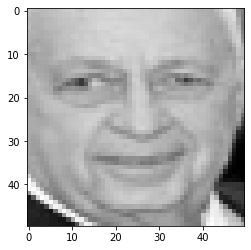

In [7]:
plt.imshow(images[0], cmap="gray")

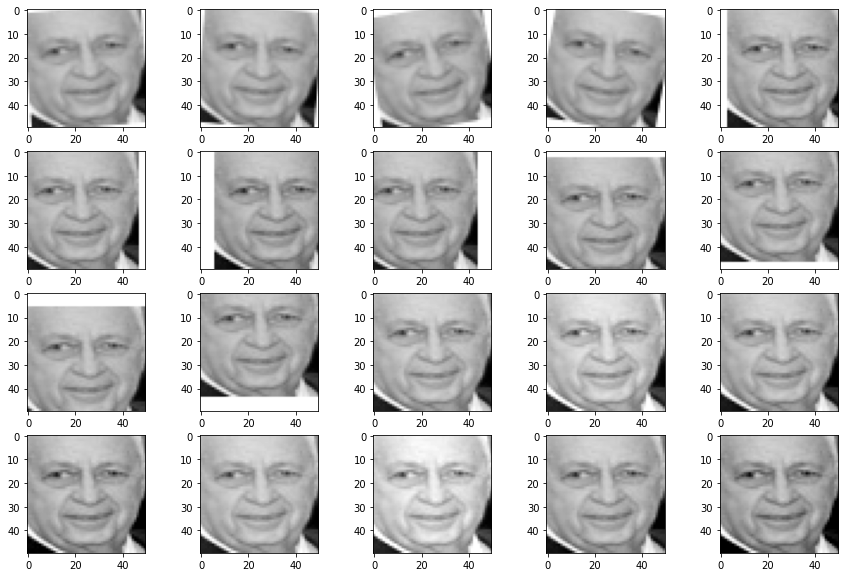

In [8]:
img_test = images[0]

augmented_image_test = img_augmentation(img_test)

plt.figure(figsize=(15,10))
for i, img in enumerate(augmented_image_test):
    plt.subplot(4,5,i+1)
    plt.imshow(img, cmap="gray")
plt.show()

In [9]:
# mengaplikasikan augmentasi ke semua file gambar
augmented_images = []
augmented_names = []
for i, img in enumerate(images):
    try :
        augmented_images.extend(img_augmentation(img))
        augmented_names.extend([names[i]] * 20)
    except :
        print(i)

In [10]:
len(augmented_images), len(augmented_names)

(22900, 22900)

In [11]:
images.extend(augmented_images)
names.extend(augmented_names)

#jumlah total gambar yang telah diaugmentasikan dengan gambar yang asli
len(images), len(names)

(24045, 24045)

# Labeling data

In [12]:
le = LabelEncoder()

le.fit(names)

labels = le.classes_

name_vec = le.transform(names)

categorical_name_vec = to_categorical(name_vec)

In [13]:
print("number of class :", len(labels))
print(labels)

number of class : 13
['Ariel_Sharon' 'Colin_Powell' 'Donald_Rumsfeld' 'George_W_Bush'
 'Gerhard_Schroeder' 'Hugo_Chavez' 'Jacques_Chirac' 'Jean_Chretien'
 'John_Ashcroft' 'Junichiro_Koizumi' 'Mifta' 'Serena_Williams'
 'Tony_Blair']


In [14]:
print(name_vec)

[ 0  0  0 ... 12 12 12]


In [15]:
print(categorical_name_vec)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [16]:
#SPLIT DATASET
x_train, x_test, y_train, y_test = train_test_split(np.array(images, dtype=np.float32),   # input data
                                                    np.array(categorical_name_vec),       # target/output data 
                                                    test_size=0.15, 
                                                    random_state=42)

In [17]:
print(x_train.shape, y_train.shape, x_test.shape,  y_test.shape)

(20438, 50, 50) (20438, 13) (3607, 50, 50) (3607, 13)


In [18]:
#RESHAPE DATA

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [19]:
x_train.shape, x_test.shape

((20438, 50, 50, 1), (3607, 50, 50, 1))

# Membuat CNN model

In [20]:
def cnn_model(input_shape):  
    model = Sequential()
    
    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu",
                    input_shape=input_shape))
    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu",
                    input_shape=input_shape))
    
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(len(labels)))  # equal to number of classes
    model.add(Activation("softmax"))
    
    model.summary() 
    
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

# Training CNN model

In [21]:
input_shape = x_train[0].shape

EPOCHS = 10
BATCH_SIZE = 64

model = cnn_model(input_shape)

history = model.fit(x_train, 
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    validation_split=0.15   # 15% of train dataset will be used as validation set
                    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 19, 19, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 128)        0         
 2D)                                                    

#### save model

In [22]:
model.save("model-cnn-facerecognition.h5")

#### predict ke semua dataset yang telah di test

In [23]:
y_pred=model.predict(x_test)

#### classification report

In [24]:
print(classification_report(y_test.argmax(axis=1), 
                            y_pred.argmax(axis=1), 
                            target_names=labels))

                   precision    recall  f1-score   support

     Ariel_Sharon       0.97      0.98      0.97       240
     Colin_Powell       0.98      0.98      0.98       492
  Donald_Rumsfeld       0.99      0.99      0.99       392
    George_W_Bush       0.98      0.99      0.98       492
Gerhard_Schroeder       0.99      0.98      0.98       355
      Hugo_Chavez       0.99      0.97      0.98       195
   Jacques_Chirac       0.98      0.98      0.98       153
    Jean_Chretien       0.95      1.00      0.97       173
    John_Ashcroft       0.97      0.96      0.96       145
Junichiro_Koizumi       0.99      0.98      0.99       195
            Mifta       0.99      1.00      1.00       143
  Serena_Williams       0.97      0.99      0.98       178
       Tony_Blair       1.00      0.96      0.98       454

         accuracy                           0.98      3607
        macro avg       0.98      0.98      0.98      3607
     weighted avg       0.98      0.98      0.98      

In [54]:
# cap = cv2.VideoCapture(0)

# my_name = "Mifta"
# os.mkdir(dataset_folder + my_name)
# num_sample = 50

# i = 0
# while cap.isOpened():
#     ret, frame = cap.read()
    
#     if ret :
#         cv2.imshow("Capture Photo", frame)
#         cv2.imwrite("dataset/%s/%s_%04d.jpg" %  (my_name, my_name, i), cv2.resize(frame, (250,250)))
        
#         if cv2.waitKey(100) == ord('q') or i == num_sample:
#             break
#         i += 1    
# cap.release()
# cv2.destroyAllWindows()

In [26]:
from keras.models import load_model

def draw_ped(img, label, x0, y0, xt, yt, color=(255,127,0), text_color=(255,255,255)):

    (w, h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    cv2.rectangle(img,
                  (x0, y0 + baseline),  
                  (max(xt, x0 + w), yt), 
                  color, 
                  2)
    cv2.rectangle(img,
                  (x0, y0 - h),  
                  (x0 + w, y0 + baseline), 
                  color, 
                  -1)  
    cv2.putText(img, 
                label, 
                (x0, y0),                   
                cv2.FONT_HERSHEY_SIMPLEX,     
                0.5,                          
                text_color,                
                1,
                cv2.LINE_AA) 
    return img

In [29]:
# --------- load Haar Cascade model -------------
facedetec = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# --------- load Keras CNN model -------------
model = load_model("model-cnn-facerecognition.h5")
print("[INFO] finish load model...")

cap = cv2.VideoCapture(0)
while cap.isOpened() :
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)
    if ret:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = facedetec.detectMultiScale(gray, 1.1, 5)
        for (x, y, w, h) in faces:
            
            face_img = gray[y:y+h, x:x+w]
            face_img = cv2.resize(face_img, (50, 50))
            face_img = face_img.reshape(1, 50, 50, 1)
            
            result = model.predict(face_img)
            idx = result.argmax(axis=1)
            confidence = result.max(axis=1)*100
            if confidence > 80:
                label_text = "%s (%.2f %%)" % (labels[idx], confidence)
            else :
                label_text = "N/A"
            frame = draw_ped(frame, label_text, x, y, x + w, y + h, color=(0,255,255), text_color=(50,50,50))
       
        cv2.imshow('Detect Face', frame)
    else :
        break
    if cv2.waitKey(10) == ord('q'):
        break
        
cv2.destroyAllWindows()
cap.release()

[INFO] finish load model...
